# **Brain Tumour Detection Using Watershed Segmentation**

## Preprocessing

### Importing The Required Libraries

In [38]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### Reading The MRI In BGR Format

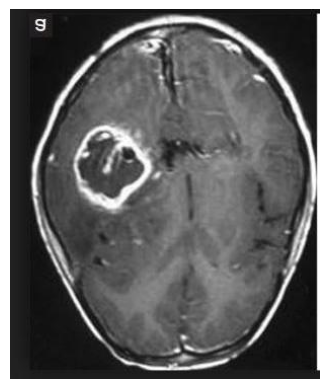

In [12]:
image = cv.imread('data/y108.jpg', 1) # 1 Indicates BGR Format
image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # Converting BGR To RGB

plt.imshow(image)
plt.axis('off')
plt.show()

### Converting the MRI Read In The Previous Step To A Grayscale Image

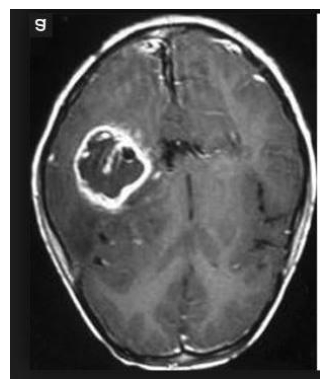

In [13]:
grayImage = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # cv.COLOR_BGR2GRAY = 6

plt.imshow(grayImage, cmap = 'gray')
plt.axis('off')
plt.show()

### Performing Filtering With The Median Filter To Remove Salt And Pepper Noise

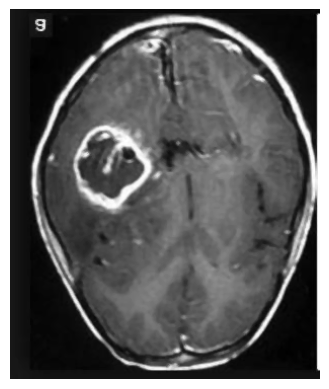

In [4]:
# 3x3 Kernel Is Used. This Is Because Kernels of Higher Order Result In The Image Looking Like A Painting
noiselessImage = cv.medianBlur(grayImage, 3) 

plt.imshow(noiselessImage, cmap = 'gray')
plt.axis('off')
plt.show()

### Detecting Edges of The MRI Using Sobel Operator

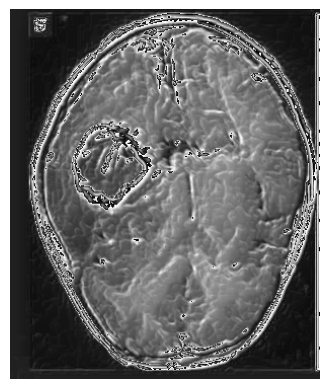

In [5]:
# 3x3 Kernel Is Used
sobelX = cv.Sobel(noiselessImage, cv.CV_8U, 1, 0, ksize = 3)
sobelY = cv.Sobel(noiselessImage, cv.CV_8U, 0, 1, ksize = 3)
sobel = sobelX + sobelY + grayImage

plt.imshow(sobel, cmap = 'gray')
plt.axis('off')
plt.show()

### Performing Thresholding On The MRI

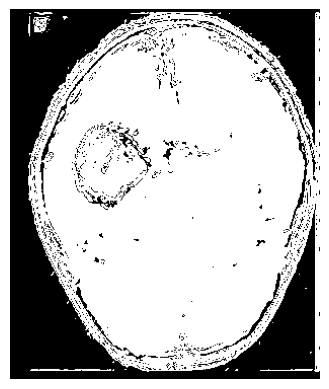

In [6]:
threshold = 50 # This Threshold Value Was Chosen After Trial And Error 
maxValue = 255
 
th, thresholdImage = cv.threshold(sobel, threshold, maxValue, cv.THRESH_BINARY)
plt.imshow(thresholdImage, cmap = 'gray')
plt.axis('off')
plt.show()

## Determining Foreground And Background of The MRI

### Performing Morphological Opening

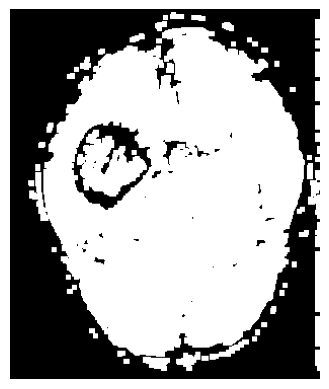

In [7]:
# Morphological Opening Is Performed To Remove Small White Noises
kernel = np.ones((3, 3), np.uint8)
opening = cv.morphologyEx(thresholdImage, cv.MORPH_OPEN, kernel, iterations = 2) # Erosing Followed By Dilation

plt.imshow(opening, cmap = 'gray')
plt.axis('off')
plt.show()

### Performing Dilation To Expand The MRI's Boundary

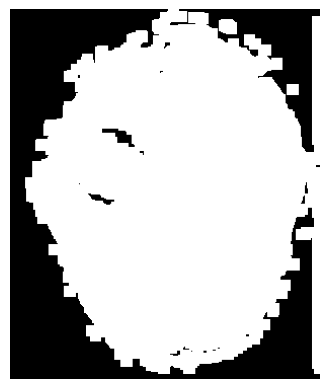

In [23]:
# The Black Region Shows The Sure Background Area
# We Can Infer That The Tumour Does Not Exist In The Given Black Background
sureBackground = cv.dilate(opening, kernel, iterations = 3) # Dilation Is Performed Iteratively 2 Times

plt.imshow(sureBackground, cmap = 'gray')
plt.axis('off')
plt.show()

### Performing Distance Transform

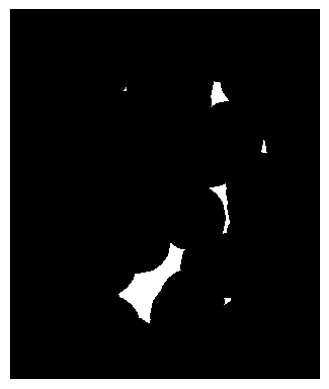

In [24]:
# The White Region Shows The Sure Foreground Area
# We Can Also Infer That The Tumour Does Not Exist In The Given White Regions
distanceTransform = cv.distanceTransform(opening, cv.DIST_L2, 5)
ret, sureForeground = cv.threshold(distanceTransform, 0.7 * distanceTransform.max(), 255, 0)

plt.imshow(sureForeground, cmap = 'gray')
plt.axis('off')
plt.show()

## Applying The Watershed Algorithm

### Calculating The Unknown Regions By Subtraction

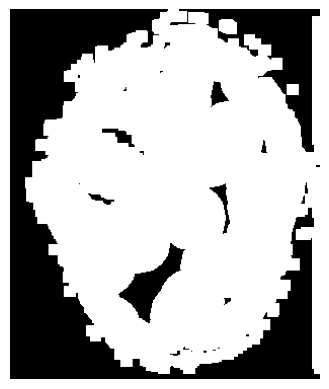

In [25]:
# Identifying The Regions Which Are Neither Foreground Nor Background
sureForeground = np.uint8(sureForeground)
unknown = cv.subtract(sureBackground, sureForeground)

plt.imshow(unknown, cmap = 'gray')
plt.axis('off')
plt.show()

### Watershed Segmentation

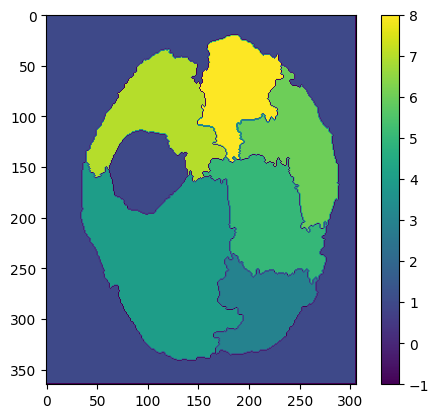

In [42]:
contours, hierarchy = cv.findContours(sureForeground, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Creating An Array For Markers Which Will Be Used To Show The Segmented MRI
marker = np.zeros((grayImage.shape[0], grayImage.shape[1]), dtype = np.int32)
marker = np.int32(sureForeground) + np.int32(sureBackground)

# Marker Labelling
for i in range(len(contours)):
    cv.drawContours(marker, contours, i, i + 2, -1)

marker = marker + 1

# To Make Sure That The Contour Lines Do Not Appear Over The Foreground (White Pixels)
marker[unknown == 255] = 0 

imageCopy = image.copy()
cv.watershed(imageCopy, marker)

watershedImage = plt.imshow(marker)
plt.colorbar()
plt.show()

### Saving The Final Watershed MRI

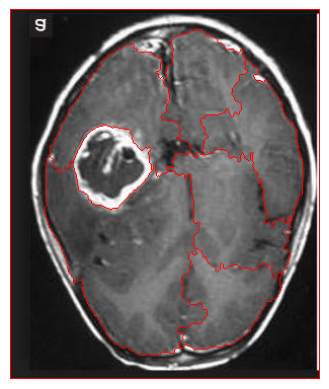

In [45]:
imageCopy[marker == -1] = (255, 0, 0)
cv.imwrite('output/img.jpg', imageCopy)
plt.imshow(imageCopy, cmap = 'gray')
plt.axis('off')
plt.show()